In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data, semi_empirical_mass_formula
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import glob
from collections import defaultdict
from copy import deepcopy
plt.style.use('~/.config/matplotlib/stylelib/mine.mplstyle')

In [2]:
import re
torch.inference_mode()
# locations = glob.glob('/checkpoint/nolte/nuclr/long-runs/*')
locations = glob.glob('/checkpoint/nolte/NuCLR-MechInterp-results/*')
print(locations)
# get train fracs for full
# all_re = re.compile(".*/epochs-50000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+).*ge8")
all_re = re.compile("epochs-200000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+)-nuclei_ge8-hiddendim1024-LR0.0003")
binding_re = re.compile(".*/long_run-binding100-seed0-trainfrac(\d+\.\d+)")
binding_semf_re = re.compile(".*/long_run-binding_semf100-seed0-trainfrac(\d+\.\d+)")
just_semf = re.compile("epochs-200000-semf.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+)-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline")
# get train fracs for partial
all_trainfracs = {}
for loc in locations:
    match = just_semf.search(loc)
    if match is not None:
      # if float(match.group(2)) > 0.7: continue
      all_trainfracs[(int(match.group(1)), float(match.group(2)))] = loc
print(len(all_trainfracs))
all_trainfracs

['/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding_semf100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-z1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-n1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-radius0.02-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qa200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm_n200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qec200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sn200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac_0.8', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac

{(0,
  1.0): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-semf100-seed0-dataseed0-trainfrac1.0-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline',
 (1,
  1.0): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-semf100-seed1-dataseed1-trainfrac1.0-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline',
 (2,
  1.0): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-semf100-seed2-dataseed2-trainfrac1.0-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline'}

In [3]:
def get_all_checkpoints_from(dir):
    checkpoints = {}
    for ckpt in os.listdir(dir):
        if ckpt.endswith('.pt') and "-" in ckpt:
            epoch = int(ckpt.split('-')[1].split('.')[0])
            if epoch % 5000 == 0: # WARNING
                checkpoints[epoch] = ckpt
    return checkpoints

def get_preds(X, model, batch=10000):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = model(X[i:i+batch])
            # preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def fix_val_mask_to_include_only_used_elements(data):
    non_nan_targets = ~torch.isnan(data.y.view(-1))
    X_train = data.X[data.train_mask & non_nan_targets]
    Z_train = X_train[:, 0].unique() 
    N_train = X_train[:, 1].unique()
    return data.val_mask & torch.isin(data.X[:, 0], Z_train) & torch.isin(data.X[:, 1], N_train)


def get_rms(model, data, split="all"):
    #filter out nans
    non_nan_targets = ~torch.isnan(data.y.view(-1))

    if split == "all":
        mask = torch.ones_like(data.y.view(-1), dtype=torch.bool)
    elif split == "train":
        mask = data.train_mask
    elif split == "val":
        mask = fix_val_mask_to_include_only_used_elements(data)
        print(mask.float().mean().item(), end="\r")

    X = data.X[non_nan_targets & mask]
    y = data.y[non_nan_targets & mask]
    

    preds = get_preds(X, model)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

In [4]:
location = all_trainfracs[(2, 1.0)]

In [5]:
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cuda:1"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(f"{location}/ckpts/model.pt"))

checkpoints = get_all_checkpoints_from(location + '/ckpts')

last_checkpoint = max(checkpoints.keys())

task_rms_values = {}
for epoch, ckpt in checkpoints.items():
    model.load_state_dict(torch.load(f"{location}/ckpts/{ckpt}"))
    task_rms_values[epoch] = get_rms(model, data, "train")["semf"]

task_rms_values

{0: 1036834.3125,
 20000: 964.963134765625,
 40000: 358.123779296875,
 60000: 173.5544891357422,
 80000: 220.3811492919922,
 100000: 474.5317077636719,
 120000: 867.907958984375,
 140000: 275.9130859375,
 160000: 633.0117797851562,
 180000: 378.59716796875}

In [6]:
model.cpu().load_state_dict(torch.load(f"{location}/ckpts/{checkpoints[last_checkpoint]}", map_location="cpu"))
model.requires_grad_(False)
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)

In [ ]:
def plot_ax0(Z_emb, ax, x_pc=0, y_pc=1, title="Z"):
    cmap = "viridis"
    import matplotlib as mpl
    Z = np.arange(len(Z_emb))
    Z = Z[9:150]
    labels = Z
    Z_emb = Z_emb[9:150]

    norm = mpl.colors.Normalize(vmin=min(Z), vmax=max(Z))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    Z = sm.to_rgba(Z)

    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=0)
    from lib.utils import PlottingContext
    PlottingContext.scatter_text(labels, Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca(), fontsize=15)
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)


pca = PCA(n_components=3)
emb_pca = pca.fit_transform(model.emb[1].detach().cpu().numpy())

# plot the embeddings Z and N are the columns
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
# PC1 vs PC0

plot_ax0(emb_pca, ax, title=None)
# PC1 vs PC0
plt.axis('off')
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig("/checkpoint/nolte/pca_semf.pdf")
plt.show()

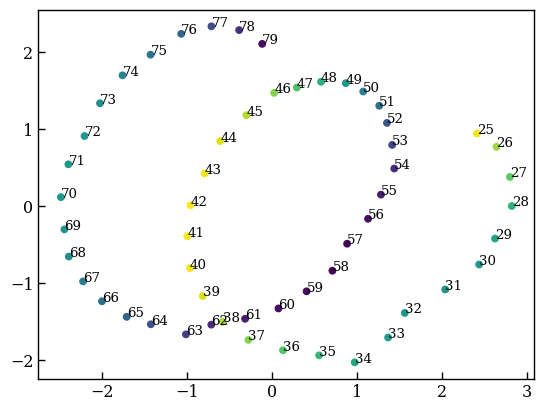

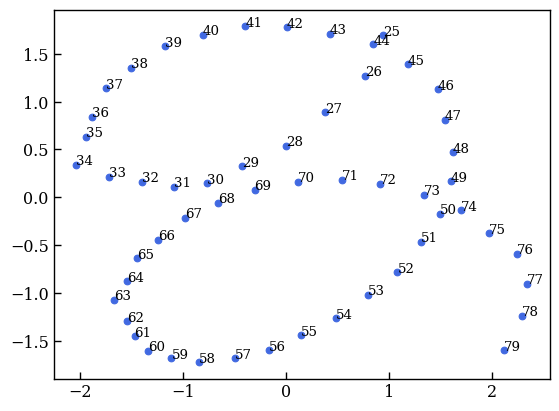

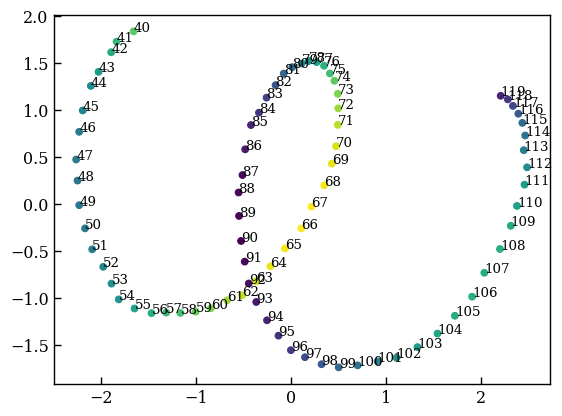

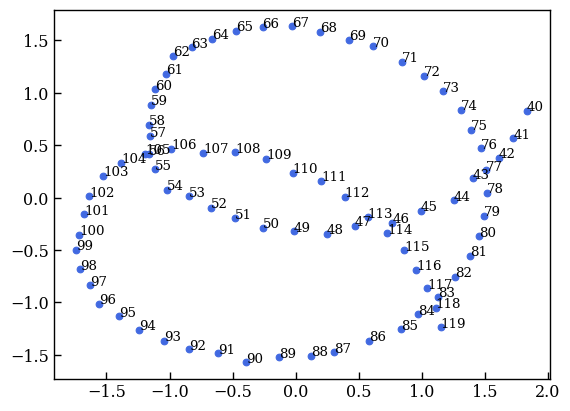

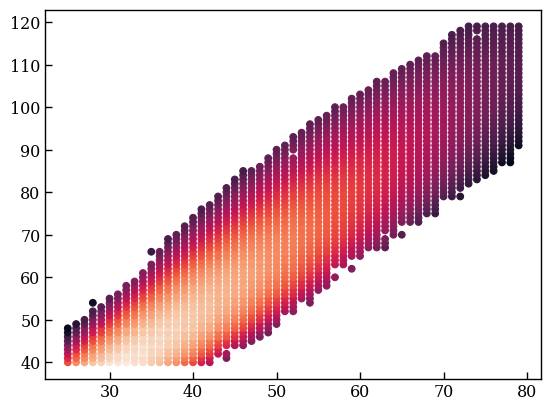

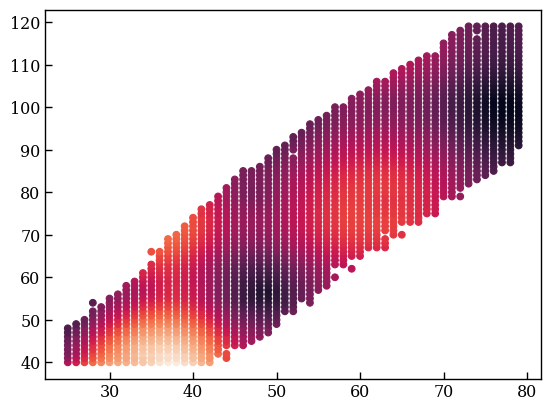

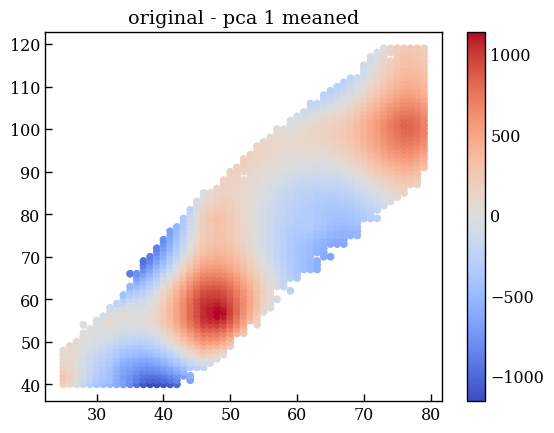

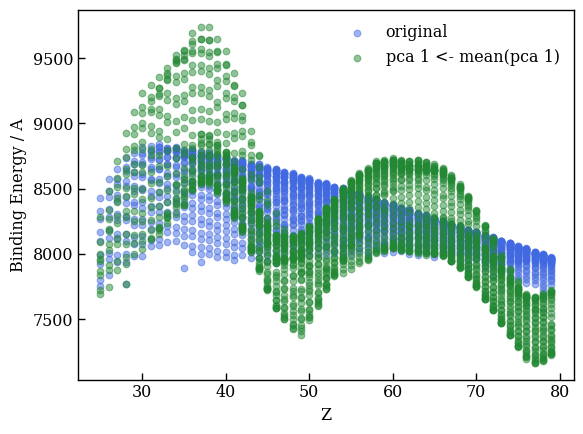

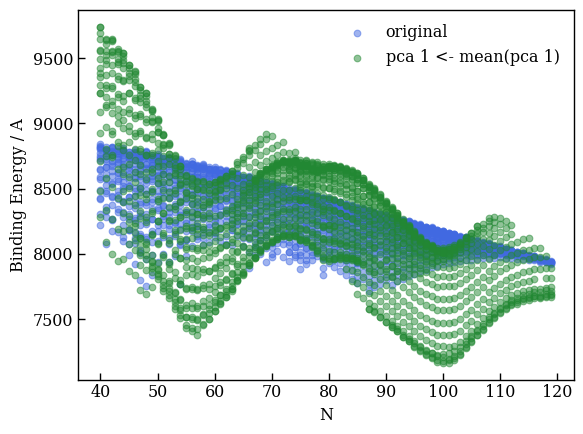

In [7]:
start_z = 25
end_z = 80
pca_z = PCA(n_components=end_z - start_z)
emb_pca_z = pca_z.fit_transform(model.emb[0][start_z:end_z].detach().cpu().numpy())
plt.scatter(emb_pca_z[:, 0], emb_pca_z[:, 1], c=emb_pca_z[:, 2], cmap='viridis')
for i, emb in enumerate(emb_pca_z):
  plt.annotate(i+start_z, emb[:2])
plt.show()

plt.scatter(emb_pca_z[:, 1], emb_pca_z[:, 2])
for i, emb in enumerate(emb_pca_z):
  plt.annotate(i+start_z, emb[[1,2]])
plt.show()

start_n = 40
end_n = 120
pca_n = PCA(n_components=end_n - start_n)
emb_pca_n = pca_n.fit_transform(model.emb[1][start_n:end_n].detach().cpu().numpy())
plt.scatter(emb_pca_n[:, 0], emb_pca_n[:, 1], c=emb_pca_n[:, 2], cmap='viridis')
for i, emb in enumerate(emb_pca_n):
  plt.annotate(i+start_n, emb[:2])
plt.show()

plt.scatter(emb_pca_n[:, 1], emb_pca_n[:, 2])
for i, emb in enumerate(emb_pca_n):
  plt.annotate(i+start_n, emb[[1,2]])
plt.show()

# TODO comment this back in
emb_pca_z[:,[1]] = emb_pca_z[:,[1]].mean(0)
emb_pca_n[:,[1]] = emb_pca_n[:,[1]].mean(0)

model_emb = deepcopy(model)
model_emb.emb[0][start_z:end_z] = torch.tensor(pca_z.inverse_transform(emb_pca_z))
model_emb.emb[1][start_n:end_n] = torch.tensor(pca_n.inverse_transform(emb_pca_n))
model_emb.readout = model.readout

sel = (data.X[:,0] >= start_z) & (data.X[:,0] < end_z) & (data.X[:,1] >= start_n) & (data.X[:,1] < end_n)  & (data.X[:,2] == 0)# & ((data.X[:,0] == 50) | (data.X[:,0] == 60))
X = data.X[sel]
output_emb = model_emb(X) / X.sum(1, keepdim=True)
output = model(X) / X.sum(1, keepdim=True)

plt.scatter(X[:, 0], X[:,1], c=output.numpy())
plt.show()
plt.scatter(X[:, 0], X[:,1], c=output_emb.numpy())
plt.show()

plt.scatter(X[:, 0], X[:,1], c=output.numpy() - output_emb.numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("original - pca 1 meaned")
plt.show()

plt.scatter(X[:, 0], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 0], output_emb.detach().cpu().numpy(), label='pca 1 <- mean(pca 1)', alpha=.5)
plt.xlabel("Z")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

plt.scatter(X[:, 1], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 1], output_emb.detach().cpu().numpy(), label='pca 1 <- mean(pca 1)', alpha=.5)
plt.xlabel("N")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

Epoch [100/3000], Loss: 0.2641
Epoch [200/3000], Loss: 0.1335
Epoch [300/3000], Loss: 0.0656
Epoch [400/3000], Loss: 0.0304
Epoch [500/3000], Loss: 0.0150
Epoch [600/3000], Loss: 0.0098
Epoch [700/3000], Loss: 0.0084
Epoch [800/3000], Loss: 0.0082
Epoch [900/3000], Loss: 0.0081
Epoch [1000/3000], Loss: 0.0081
Epoch [1100/3000], Loss: 0.0081
Epoch [1200/3000], Loss: 0.0082
Epoch [1300/3000], Loss: 0.0081
Epoch [1400/3000], Loss: 0.0081
Epoch [1500/3000], Loss: 0.0081
Epoch [1600/3000], Loss: 0.0081
Epoch [1700/3000], Loss: 0.0081
Epoch [1800/3000], Loss: 0.0081
Epoch [1900/3000], Loss: 0.0081
Epoch [2000/3000], Loss: 0.0081
Epoch [2100/3000], Loss: 0.0081
Epoch [2200/3000], Loss: 0.0081
Epoch [2300/3000], Loss: 0.0081
Epoch [2400/3000], Loss: 0.0081
Epoch [2500/3000], Loss: 0.0081
Epoch [2600/3000], Loss: 0.0082
Epoch [2700/3000], Loss: 0.0081
Epoch [2800/3000], Loss: 0.0081
Epoch [2900/3000], Loss: 0.0081
Epoch [3000/3000], Loss: 0.0081


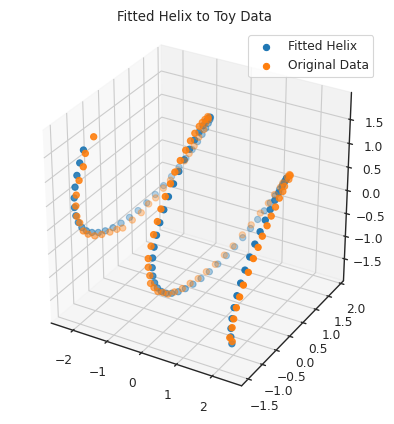

Epoch [100/3000], Loss: 0.7157
Epoch [200/3000], Loss: 0.2724
Epoch [300/3000], Loss: 0.1215
Epoch [400/3000], Loss: 0.0854
Epoch [500/3000], Loss: 0.0761
Epoch [600/3000], Loss: 0.0735
Epoch [700/3000], Loss: 0.0727
Epoch [800/3000], Loss: 0.0726
Epoch [900/3000], Loss: 0.0725
Epoch [1000/3000], Loss: 0.0725
Epoch [1100/3000], Loss: 0.0725
Epoch [1200/3000], Loss: 0.0725
Epoch [1300/3000], Loss: 0.0725
Epoch [1400/3000], Loss: 0.0725
Epoch [1500/3000], Loss: 0.0725
Epoch [1600/3000], Loss: 0.0725
Epoch [1700/3000], Loss: 0.0725
Epoch [1800/3000], Loss: 0.0725
Epoch [1900/3000], Loss: 0.0725
Epoch [2000/3000], Loss: 0.0725
Epoch [2100/3000], Loss: 0.0725
Epoch [2200/3000], Loss: 0.0725
Epoch [2300/3000], Loss: 0.0725
Epoch [2400/3000], Loss: 0.0725
Epoch [2500/3000], Loss: 0.0725
Epoch [2600/3000], Loss: 0.0725
Epoch [2700/3000], Loss: 0.0726
Epoch [2800/3000], Loss: 0.0725
Epoch [2900/3000], Loss: 0.0725
Epoch [3000/3000], Loss: 0.0725


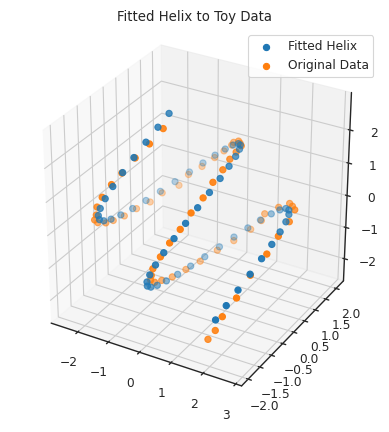

In [8]:

def find_orthonormal_basis(a):
    """
    Find two orthonormal vectors that are perpendicular to the vector a in PyTorch.
    """
    if a[0] != 0 or a[1] != 0:
        v1 = torch.tensor([-a[1], a[0], 0], dtype=torch.float32)
    else:
        v1 = torch.tensor([0, -a[2], a[1]], dtype=torch.float32)
    v1 = v1 / torch.norm(v1)
    v2 = torch.cross(a, v1)
    return v1, v2

def helix(t, R, F, P, axis, start, phase, final_linear):
    """
    Parametric equations for a 3D spiral (helix) around a specified axis in PyTorch.
    """
    # Normalize the axis
    a = axis / torch.norm(axis)
    
    # Find two orthonormal vectors perpendicular to the axis
    u, v = find_orthonormal_basis(a)

    # Circular motion around the axis
    V_perp = R * (torch.cos(2*torch.pi * F * t + phase)[:, None] * u + torch.sin(2*torch.pi*F * t + phase)[:, None] * v)

    # Movement along the axis
    V_axis = P * t[:, None] * a

    return (V_perp + V_axis + start) @ final_linear


# Toy data generation
# t = torch.linspace(0, 5, len(emb_pca))
# R_true = 1
# F_true = 0.3 * 2 * torch.pi
# P_true = 4
# axis_true = torch.tensor([1., 0., 1.], dtype=torch.float32)  # Arbitrary axis
# start_point = torch.tensor([0., 0., 0.], dtype=torch.float32)  # Arbitrary start point

# Generating the helix data
# data = helix(t, R_true, F_true, P_true, axis_true, start_point)
emb_pca_z = pca_z.transform(model.emb[0][start_z:end_z].detach().cpu().numpy())
emb_pca_n = pca_n.transform(model.emb[1][start_n:end_n].detach().cpu().numpy())

def get_spiral_preds(emb_pca):
  data_spiral = torch.tensor(emb_pca[:,:3], requires_grad=False)

  # Parameters as PyTorch tensors
  t = torch.linspace(0, 1, len(data_spiral), requires_grad=False)
  R = torch.tensor(1.0, requires_grad=True)  # Radius
  F = torch.tensor(2., requires_grad=True)  # Frequency
  P = torch.tensor(5., requires_grad=True)  # Pitch
  axis = torch.tensor([1.,0.,0.], requires_grad=True, dtype=torch.float32)  # Axis of the spiral
  starto = torch.tensor([-3.,-1,0.], requires_grad=True, dtype=torch.float32)  # Start point of the spiral
  phase = torch.tensor(0.5, requires_grad=True)  # Phase shift of the spiral
  final_linear = torch.eye(3, requires_grad=True, dtype=torch.float32)

  with torch.no_grad():
    initial_guess = helix(t, R, F, P, axis, starto, phase, final_linear)

  # # Optimizer
  optimizer = torch.optim.Adam([R, F, P, axis, starto, final_linear], lr=0.01)

  # Loss function
  def loss_fn(predicted, target):
      return ((predicted - target)**2).mean()

  # Training loop
  epochs = 3000
  for epoch in range(epochs):
      optimizer.zero_grad()
      predicted = helix(t, R, F, P, axis, starto, phase, final_linear)
      loss = loss_fn(predicted, data_spiral)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

  # Plotting the results
  predicted = helix(t, R, F, P, axis, starto, phase, final_linear).detach().numpy()
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d', aspect='equal')
  ax.scatter(predicted[:, 0], predicted[:, 1], predicted[:, 2], label='Fitted Helix')
  ax.scatter(data_spiral[:, 0], data_spiral[:, 1], data_spiral[:, 2], label='Original Data')
  # ax.scatter(initial_guess[:, 0], initial_guess[:, 1], initial_guess[:, 2], label='Initial Guess')
  # plot the vectors
  plt.title('Fitted Helix to Toy Data')
  plt.legend()
  plt.show()
  return predicted, {'t':t, 'R': R, 'F': F, 'P': P, 'axis': axis, 'start': starto, 'phase': phase, 'final_linear': final_linear}

predicted_n, spiral_n_params = get_spiral_preds(emb_pca_n)
predicted_z, spiral_z_params = get_spiral_preds(emb_pca_z)
diff_n = emb_pca_n[:, :3] - predicted_n
diff_z = emb_pca_z[:, :3] - predicted_z

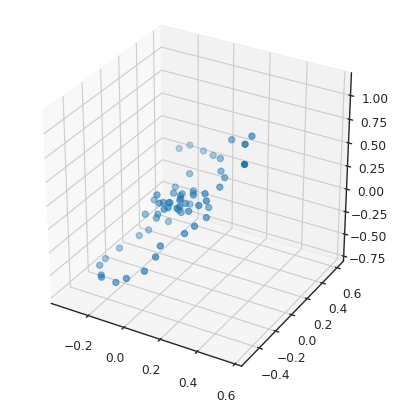

In [9]:
# 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax.scatter(*(predicted_z - emb_pca_z[:,:3]).T)

In [10]:
from copy import deepcopy
with torch.no_grad():
  model_spiral = deepcopy(model)
  model_spiral.readout = model.readout

  spiral_embs_n = emb_pca_n.copy()
  spiral_embs_n[:, :3] = helix(**spiral_n_params) + diff_n
  # spiral_embs_n[:, :3] += torch.randn(spiral_embs_n[:, :3].shape).numpy()*.2
  spiral_embs_n = pca_n.inverse_transform(spiral_embs_n)
  spiral_embs_n = torch.tensor(spiral_embs_n, device=args.DEV).float()
  model_spiral.emb[1][start_n:end_n] = spiral_embs_n

  spiral_embs_z = emb_pca_z.copy()
  spiral_embs_z[:, :3] = helix(**spiral_z_params) + diff_z
  # spiral_embs_z[:, :3] += torch.randn(spiral_embs_z[:, :3].shape).numpy()*.2
  spiral_embs_z = pca_z.inverse_transform(spiral_embs_z)
  spiral_embs_z = torch.tensor(spiral_embs_z, device=args.DEV).float()
  model_spiral.emb[0][start_z:end_z] = spiral_embs_z

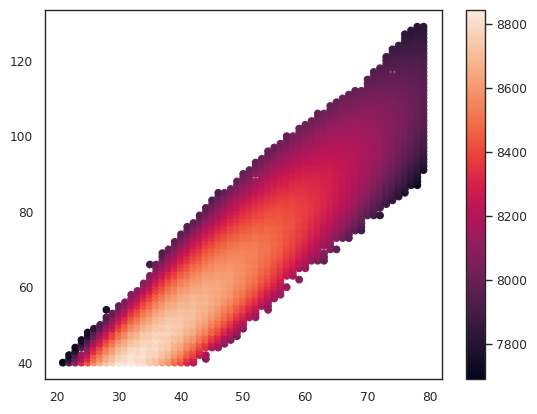

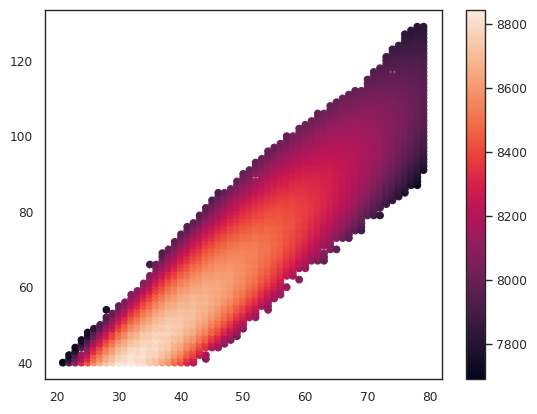

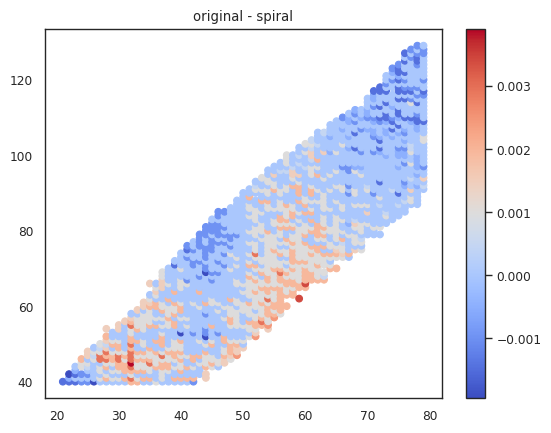

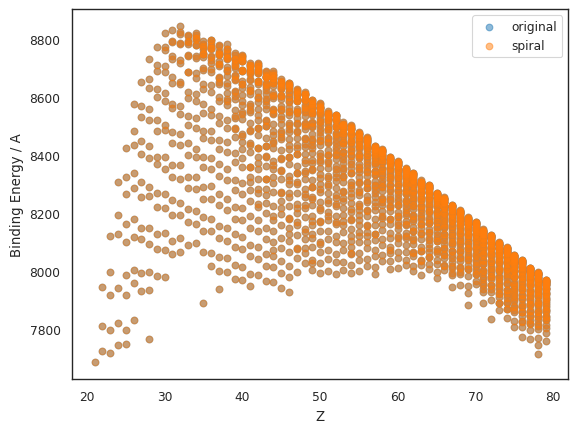

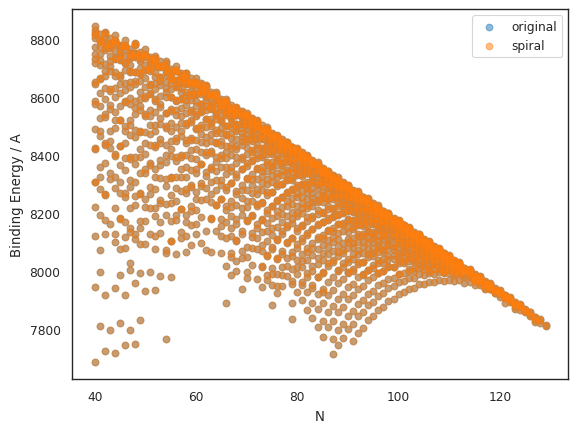

In [11]:
output_spiral = model_spiral(X) / X.sum(1, keepdim=True)
output = model(X) / X.sum(1, keepdim=True)

plt.scatter(X[:, 0], X[:,1], c=output.numpy())
plt.colorbar()
plt.show()
plt.scatter(X[:, 0], X[:,1], c=output_spiral.numpy())
plt.colorbar()
plt.show()

plt.scatter(X[:, 0], X[:,1], c=output.numpy() - output_spiral.numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("original - spiral")
plt.show()

plt.scatter(X[:, 0], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 0], output_spiral.detach().cpu().numpy(), label='spiral', alpha=.5)
plt.xlabel("Z")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

plt.scatter(X[:, 1], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 1], output_spiral.detach().cpu().numpy(), label='spiral', alpha=.5)
plt.xlabel("N")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

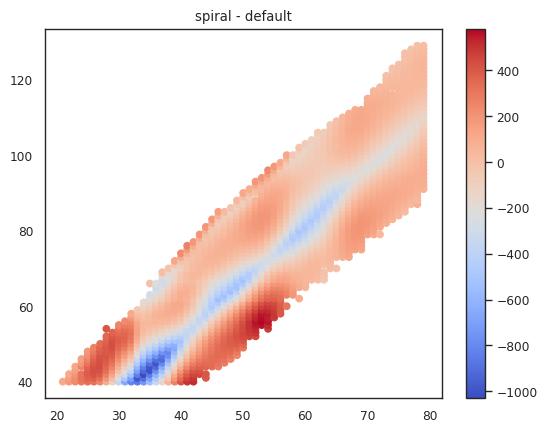

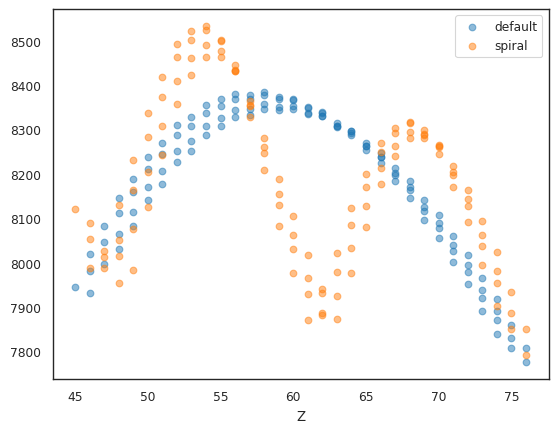

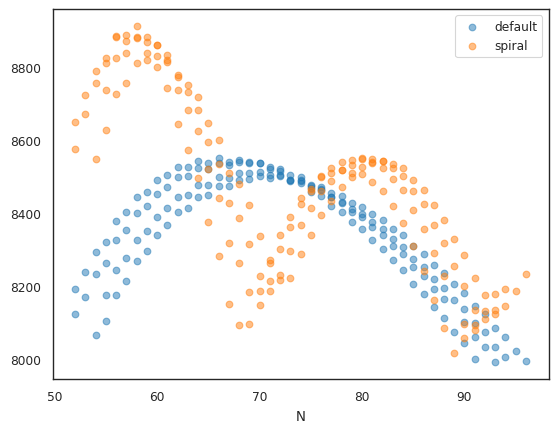

In [25]:
@torch.no_grad()
def get_spiral_outputs(params_n, params_z):
    helix_n = helix(**params_n).cpu().numpy() + diff_n
    helix_z = helix(**params_z).cpu().numpy() + diff_z

    model_spiral = deepcopy(model)
    model_spiral.readout = model.readout

    spiral_embs_n = emb_pca_n.copy()
    spiral_embs_n[:, :3] = helix_n
    spiral_embs_n = pca_n.inverse_transform(spiral_embs_n)
    spiral_embs_n = torch.tensor(spiral_embs_n, device=args.DEV).float()
    model_spiral.emb[1][start_n:end_n] = spiral_embs_n

    spiral_embs_z = emb_pca_z.copy()
    spiral_embs_z[:, :3] = helix_z
    spiral_embs_z = pca_z.inverse_transform(spiral_embs_z)
    spiral_embs_z = torch.tensor(spiral_embs_z, device=args.DEV).float()
    model_spiral.emb[0][start_z:end_z] = spiral_embs_z
    
    output_spiral = model_spiral(X) / X.sum(1, keepdim=True)
    return output_spiral

# plot the output as a function of spiral parameters
def plot_output_with_params(params_n : dict, params_z : dict, best_params_n:dict, best_params_z:dict):
  with torch.no_grad():
    output_spiral = get_spiral_outputs(params_n, params_z)  
    output_spiral_best = get_spiral_outputs(best_params_n, best_params_z)
    output_default = model(X) / X.sum(1, keepdim=True)
    
    # plt.title("best_spiral - spiral")
    # plt.scatter(X[:, 0], X[:,1], c=output_spiral.numpy() - output_spiral_best.numpy(), cmap="coolwarm")
    # plt.colorbar()
    # plt.show()

    plt.title("spiral - default")
    plt.scatter(X[:, 0], X[:,1], c=output_spiral.numpy() - output_default.numpy(), cmap="coolwarm")
    plt.colorbar()
    plt.show()

    # plt.title("best spiral - default")
    # plt.scatter(X[:, 0], X[:,1], c=output_spiral_best.numpy() - output_default.numpy(), cmap="coolwarm")
    # plt.colorbar()
    # plt.show()


    sel_z = (X[:,1] > 82) & (X[:,1] < 87)
    # sel_z = X[:,1] > 0
    plt.scatter(X[:,0][sel_z], output_default[sel_z].detach().cpu().numpy(), label='default', alpha=.5)
    # plt.scatter(X[:,0][sel_z], output_spiral_best[sel_z].detach().cpu().numpy(), label='spiral', alpha=.5)
    plt.scatter(X[:,0][sel_z], output_spiral[sel_z].detach().cpu().numpy(), label='spiral', alpha=.5)
    plt.xlabel("Z")
    plt.legend()
    plt.show()

    sel_n = (X[:,0] > 50) & (X[:,0] < 55)
    # sel_n = X[:,0] > 0
    plt.scatter(X[:,1][sel_n], output_default[sel_n].detach().cpu().numpy(), label='default', alpha=.5)
    # plt.scatter(X[:,1][sel_n], output_spiral_best[sel_n].detach().cpu().numpy(), label='spiral', alpha=.5)
    plt.scatter(X[:,1][sel_n], output_spiral[sel_n].detach().cpu().numpy(), label='spiral', alpha=.5)
    plt.xlabel("N")
    plt.legend()
    plt.show()

with torch.no_grad():
  best_params = {"best_params_n": spiral_n_params, "best_params_z": spiral_z_params}

  new_params = {"params_n": deepcopy(spiral_n_params), "params_z": deepcopy(spiral_z_params)}

  # new_params["params_n"]["R"] *= 2
  # new_params["params_z"]["R"] *= 2
  # new_params["params_z"]["P"] *= 1.5
  # new_params["params_n"]["P"] *= 1.5
  # new_params["params_n"]["start"] -= .5
  new_params["params_n"]["F"] *= 2
  new_params["params_z"]["F"] *= 2
  # new_params["params_n"]["R"] *= 30
  # new_params["params_z"]["F"] *= 2

  
  plot_output_with_params(**new_params, **best_params)

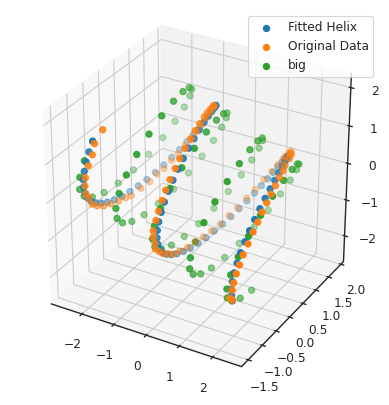

In [23]:
with torch.no_grad():
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d', aspect='equal')
  ax.scatter(predicted_n[:, 0], predicted_n[:, 1], predicted_n[:, 2], label='Fitted Helix')
  ax.scatter(emb_pca_n[:, 0], emb_pca_n[:, 1], emb_pca_n[:, 2], label='Original Data')
  ax.scatter(*helix(**new_params["params_n"])[:,:3].T, label="big")
  plt.legend()
  plt.show()